In [1]:
import sys
sys.path.insert(0, "../../.")

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from functions.general_functions import b_any_series, simulate_rectangular, simulate_randomfield, simulate_sinus, simulate_step, simulate_ramp
from functions.general_functions import ks_test_b_dist, inverse_norm, transform_n
from functions.eval_functions import pval_mac, mu_sigma_mac
from functions.one_dimensional import mac_one_dimension
from scipy.stats import norm

from seismostats import estimate_b, plot_cum_fmd, simulate_magnitudes_binned
%config InlineBackend.figure_format ='retina'

# Fig S1: transformation of b-values

In [2]:
# generate synthetic magnitudes, b-value series and histograms
n_total = 50000
mc = 0
delta_m = 0.1
dates = np.arange(n_total)

# 1
n_m1 = 200
b = 1
mags1 = simulate_magnitudes_binned(n_total, b, mc, delta_m)
b_true1 = np.ones(len(mags1)) * b
b_time1, idx_max1, b_std1 = b_any_series(mags1, dates, n_m= n_m1, mc=mc, delta_m=delta_m, return_std=True, overlap=1, method='tinti')
b_all = estimate_b(mags1, mc, delta_m)

# 2 transform
n_m2 = 500
b_time2 = transform_n(b_time1, b_all,n_m1, n_m2)



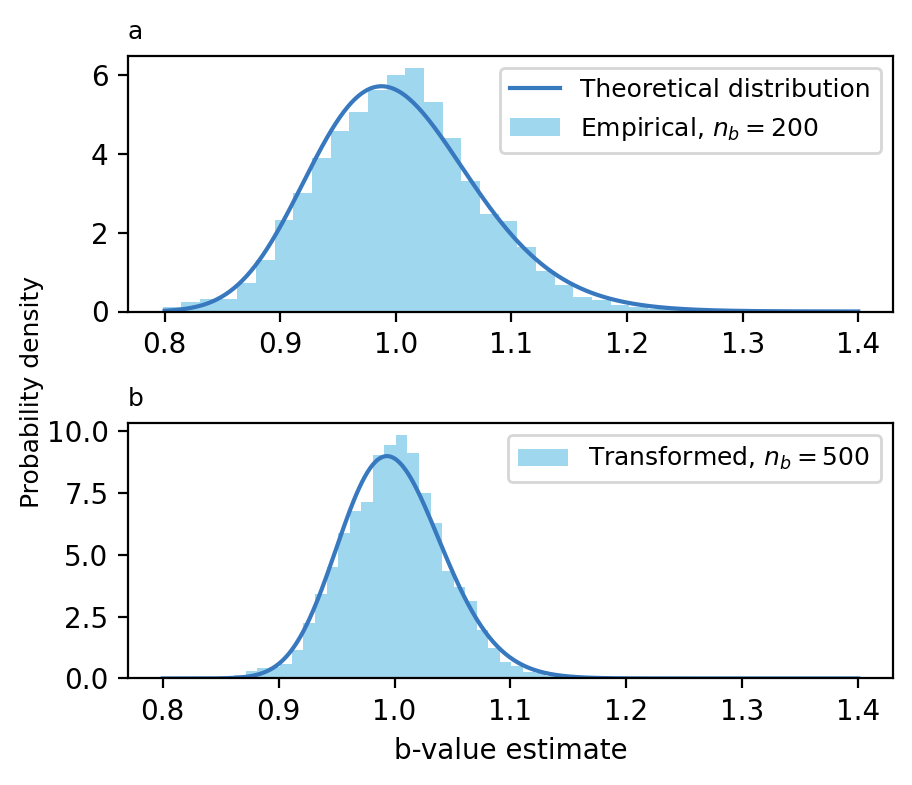

In [3]:
fig, ax = plt.subplots(2, 1, figsize=(4.5, 4))

b_est = np.linspace(0.8, 1.4, 500)

# Create a figure
plt.rcParams.update({'font.size': 9})

ax[0].plot(b_est, inverse_norm(b_est, b_all, n_m1), color = '#3778bf', label='Theoretical distribution')
ax[0].hist(b_time1 , color='skyblue', density=True, label='Empirical, $n_b = 200$', alpha=0.8, bins=30)
ax[0].legend()
ax[0].set_title('a', fontsize=9, loc='left')

ax[1].plot(b_est,inverse_norm(b_est, b_all, n_m2), color = '#3778bf')
ax[1].hist(b_time2 , color='skyblue', density=True, label='Transformed, $n_b = 500$', alpha=0.8, bins=30)
ax[1].legend()
ax[1].set_title('b', fontsize=9, loc='left')

plt.xlabel('b-value estimate')

# put the y label in the middle of the two plots
fig.text(0, 0.5, 'Probability density', va='center', rotation='vertical')

plt.tight_layout()

# Fig S2: Verification of the distribution of the MAC (1D)

# Fig S3: Estimation of gamma factor for two partitioning techniques

# Fig S4: Length scale analysis details -> see length_scale_IG.ipynb